# Model Training

Here you will load the images, create a model and train it.

## Setup

In [26]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential


Specify the dataset directory and the ordered list of labels.

In [27]:
dataset_dir = './dataset'
class_names = ['left','straight','right']

## Data preprocessing

Define a function to preprocess each image

In [28]:
def preprocess(image):
    scale_percent = 40 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

Read in each image in the dataset directory, run the preprocessing and then them into a list called `data`. Create a corresponding list of the assigned labels called `data_labels`.  Then at the end, convert the lists to numpy arrays.

In [29]:
data = []
data_labels = []

for class_idx,class_name in enumerate(class_names):
    dir_name = os.path.join(dataset_dir,class_name)
    for file in os.listdir(dir_name):
        if file.endswith('.png'):
            full_path = os.path.join(dir_name,file)
            image = cv2.imread(full_path)
            preprocessed_image = preprocess(image)
            data.append(preprocessed_image)
            data_labels.append(class_idx)

data = np.array(data)
data_labels = np.array(data_labels)



#--------------- Mirror functionality written by lucanatorvs -------------------------------------------------------------

# we mirror the data to increase the dataset, every image is flipped horizontally, and the label is changed accordingly; left becomes right, right becomes left and straight stays straight

data_mirror = np.flip(data,2)
data_mirror_labels = np.copy(data_labels)
data_mirror_labels[data_mirror_labels == 0] = 3
data_mirror_labels[data_mirror_labels == 2] = 0
data_mirror_labels[data_mirror_labels == 3] = 2

# now we concatenate the original data and the mirrored data to get a bigger dataset
data = np.concatenate((data,data_mirror),axis=0)
data_labels = np.concatenate((data_labels,data_mirror_labels),axis=0)

# now crop the top 20 pixels from the image, to remove the sky and the horizon
data = data[:,25:,:]
#--------------------------------------------------------------------------------------------------------------------------
print(data.shape)
print(data_labels.shape)

(454, 64, 89, 3)
(454,)


Plot some of the images to make sure everything went okay.

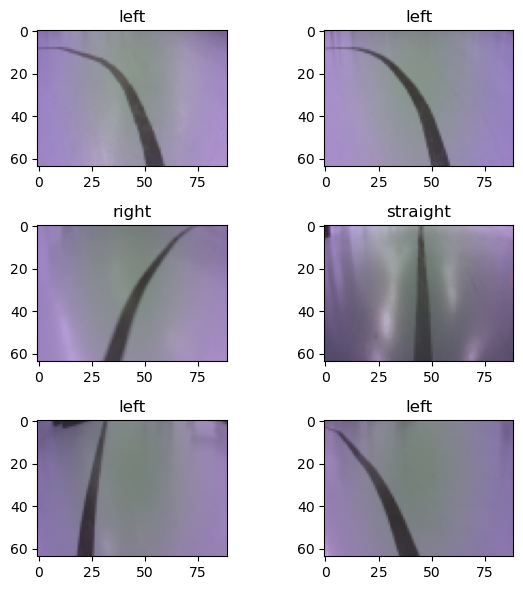

In [30]:
rows = 3
columns = 2
fig, axes = plt.subplots(rows,columns,figsize=(6,6))
for i,ax in enumerate(axes.ravel()):
    idx = random.choice(range(data.shape[0]))
    ax.imshow(data[idx],cmap='gray')
    ax.set_title(class_names[data_labels[idx]])
fig.tight_layout()

Check the dataset dimesions to see how many instances and labels there are.

In [31]:
print("Dataset shape:",data.shape)
print("Labels shape:", data_labels.shape)

Dataset shape: (454, 64, 89, 3)
Labels shape: (454,)


## Data Splitting / Model Definition / Training / Evaluation

At this point you have succefully prepared your images for training.  Now you have to split this data into training validation, and test sets, then create a suitable model, train it and then test it, and finally if you are satisfied with your performance you can save the model. The saved model can be later loaded in your Jetracer for deployment.

X_train shape: (290, 64, 89, 3)
X_val shape: (73, 64, 89, 3)
X_test shape: (91, 64, 89, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 89, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 89, 8)         224       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 44, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 44, 16)        1168      
                                                                 
 flatten_3 (Flatten)         (None, 22528)             0         
                                                                 
 dropout_3 (Dropout)         

<AxesSubplot:>

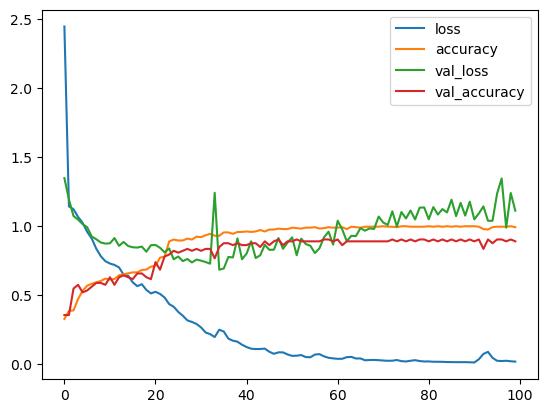

In [32]:
# ----------------- Written by lucanatorvs --------------------------------------------------------------
# first we make a test set, and then we split the remaining data into a validation and a training set
X_train, X_test, y_train, y_test = train_test_split(
    data, data_labels, test_size=0.2, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=69)

# now we print the shape of the data
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
# -------------------------------------------------------------------------------------------------------


# -------- Model is WIP, should be changed to CNN -------------------------------------------------------

model = Sequential([
    layers.Rescaling(1./255, input_shape=(64, 89, 3)),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(3)
])

# return the constructed network architecture


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

print(model.summary())
trained = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val))
df = pd.DataFrame(trained.history)
df.plot()


## Saving a TensorFlow Lite Model

Choose an appropriate output file name for your `.tflite` file.  It may help to use version numbers, and keep track of versions

In [33]:
output_filename = './mini_proj_model_v01_01.tflite'

Convert your model (in the variable `model`) and save the `.tflite` file

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()

# This will save your model with the a file name tflite_model_fp16_file.tflite. You can uplaod this model file
# in your JetRacer a

with open(output_filename, 'wb') as f:
    f.write(tflite_fp16_model)


INFO:tensorflow:Assets written to: C:\Users\joskn\AppData\Local\Temp\tmp7y5gbb32\assets


INFO:tensorflow:Assets written to: C:\Users\joskn\AppData\Local\Temp\tmp7y5gbb32\assets
